In [ ]:
%reload_ext autoreload
%autoreload 2

import sys
import warnings

warnings.filterwarnings("ignore")
import torch
import numpy as np
import pandas as pd
from numpy.random import uniform
from torch_geometric.loader import DataLoader
import colorlog
from pathlib import Path

In [ ]:
n_evts, n_sectors = 10, 32

In [ ]:
from gnn_tracking.preprocessing.point_cloud_builder import PointCloudBuilder

# build point clouds for each sector in the pixel layers only
pc_builder = PointCloudBuilder(
    indir="/tigress/jdezoort/codalab/train_1",
    outdir=Path("~/data/gnn_tracking/point_clouds/").expanduser(),
    n_sectors=n_sectors,
    pixel_only=True,
    redo=False,
    measurement_mode=False,
    sector_di=0,
    sector_ds=1.3,
    thld=0.9,
    log_level=1,
)
pc_builder.process(n=n_evts)

In [ ]:
# each point cloud is a PyG Data object
point_cloud = pc_builder.data_list
pc_builder.get_measurements()

In [ ]:
# we can build graphs on the point clouds using geometric cuts
from gnn_tracking.graph_construction.graph_builder import GraphBuilder

graph_builder = GraphBuilder(
    indir=Path("~/data/gnn_tracking/point_clouds/").expanduser(),
    outdir=Path("~/data/gnn_tracking/graphs/").expanduser(),
    redo=False,
    measurement_mode=False,
    phi_slope_max=0.0035,
    z0_max=200,
    dR_max=2.3,
)
graph_builder.process(n=n_evts * n_sectors)
graph_builder.get_measurements()

In [ ]:
from gnn_tracking.models.track_condensation_networks import GraphTCN
from gnn_tracking.training.tcn_trainer import TCNTrainer
from gnn_tracking.utils.losses import (
    EdgeWeightBCELoss,
    PotentialLoss,
    BackgroundLoss,
    ObjectLoss,
)

# use cuda (gpu) if possible, otherwise fallback to cpu
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Utilizing {device}")

# use reference graph to get relevant dimensions
g = graph_builder.data_list[0]
node_indim = g.x.shape[1]
edge_indim = g.edge_attr.shape[1]
hc_outdim = 2  # output dim of latent space

# partition graphs into train, test, val splits
graphs = graph_builder.data_list
n_graphs = len(graphs)
rand_array = uniform(low=0, high=1, size=n_graphs)
train_graphs = [g for i, g in enumerate(graphs) if (rand_array <= 0.6)[i]]
test_graphs = [
    g for i, g in enumerate(graphs) if ((rand_array > 0.6) & (rand_array <= 0.8))[i]
]
val_graphs = [g for i, g in enumerate(graphs) if (rand_array > 0.8)[i]]

# build graph loaders
params = {"batch_size": 1, "shuffle": True, "num_workers": 2}
train_loader = DataLoader(list(train_graphs), **params)
params = {"batch_size": 1, "shuffle": False, "num_workers": 2}
test_loader = DataLoader(list(test_graphs), **params)
val_loader = DataLoader(list(val_graphs), **params)
loaders = {"train": train_loader, "test": test_loader, "val": val_loader}
print("Loader sizes:", [(k, len(v)) for k, v in loaders.items()])

# build loss function dictionary
q_min, sb = 0.01, 0.1
loss_functions = {
    "edge": EdgeWeightBCELoss().to(device),
    "potential": PotentialLoss(q_min=q_min, device=device),
    "background": BackgroundLoss(device=device, sb=sb),
    # "object": ObjectLoss(device=device, mode='efficiency')
}

loss_weights = {
    # everything that's not mentioned here will be 1
    "edge": 5,
    "potential_attractive": 10,
    "potential_repulsive": 1,
    "background": 5,
    # "object": 1/250000,
}

# set up a model and trainer
model = GraphTCN(node_indim, edge_indim, hc_outdim, hidden_dim=64)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
n_params = sum([np.prod(p.size()) for p in model_parameters])
print("number trainable params:", n_params)
trainer = TCNTrainer(
    model=model,
    loaders=loaders,
    loss_functions=loss_functions,
    lr=0.0001,
    loss_weights=loss_weights,
    device=device,
)
print(trainer.loss_functions)

trainer.train()

In [ ]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
import time

model.eval()
out = model(g.to(device))
h = out["H"].detach().cpu().numpy()
beta = out["B"].detach().cpu().numpy()
w = out["W"]
particle_id = g.particle_id.cpu()

In [22]:
for ievt in range(10):
    for isec in range(32):
        i = ievt * 32 + isec
        g = graph_builder.data_list[i]
        particle_id = g.particle_id.cpu()
        out = model(g.to(device))
        h = out["H"].detach().cpu().numpy()
        with open(f"{ievt}_{isec}.npy", "wb") as outf:
            np.save(outf, h)
        with open(f"t_{ievt}_{isec}.npy", "wb") as outf:
            np.save(outf, particle_id)

In [7]:
import collections

In [8]:
class DBScanner:
    def __init__(
        self,
    ):
        self.opt_clusters = None

        self.metrics = collections.defaultdict(list)
        self.eps = []
        self.min_pts = []

    def scan(self, h, particle_id, n_trials=100):
        for _ in range(n_trials):
            eps = np.random.uniform()
            min_pts = np.random.randint(1, 5)
            self.eps.append(eps)
            self.min_pts.append(min_pts)
            db = DBSCAN(eps=eps, min_samples=min_pts).fit(h)
            c = db.labels_
            e1 = self.get_effs(c, h, particle_id)
            e2 = self.get_effs2(c, h, particle_id)
            effs = {**e1, **e2}
            for k, v in effs.items():
                self.metrics[k].append(v)
            self.clabels = db.labels_

    def get_effs(self, c, h, particle_id):
        c_id = pd.DataFrame({"c": c, "id": particle_id})
        clusters = c_id.groupby("c")
        majority_pid = clusters["id"].apply(lambda x: x.mode()[0])
        majority_counts = clusters["id"].apply(lambda x: sum(x == x.mode()[0]))
        majority_fraction = clusters["id"].apply(
            lambda x: sum(x == x.mode()[0]) / len(x)
        )
        h_id = pd.DataFrame({"hits": np.ones(len(h)), "id": particle_id})
        particles = h_id.groupby("id")
        nhits = particles["hits"].apply(lambda x: len(x)).to_dict()
        majority_hits = clusters["id"].apply(lambda x: x.mode().map(nhits)[0])
        perfect_match = (majority_hits == majority_counts) & (majority_fraction > 0.99)
        double_majority = ((majority_counts / majority_hits).fillna(0) > 0.5) & (
            majority_fraction > 0.5
        )
        lhc_match = (majority_fraction).fillna(0) > 0.75
        return {
            "total": len(c),
            "perfect": sum(perfect_match),
            "double_majority": sum(double_majority),
            "lhc": sum(lhc_match),
        }

    def get_effs2(self, c, h, particle_id):
        labels, labels_true = c, particle_id
        return {
            "homogeneity": metrics.homogeneity_score(labels_true, labels),
            "completeness": metrics.completeness_score(labels_true, labels),
            "v_measure": metrics.v_measure_score(labels_true, labels),
            "adjusted_rand_index": metrics.adjusted_rand_score(labels_true, labels),
        }

In [9]:
dbscanner = DBScanner()

In [16]:
dbscanner.scan(h, particle_id, n_trials=500)

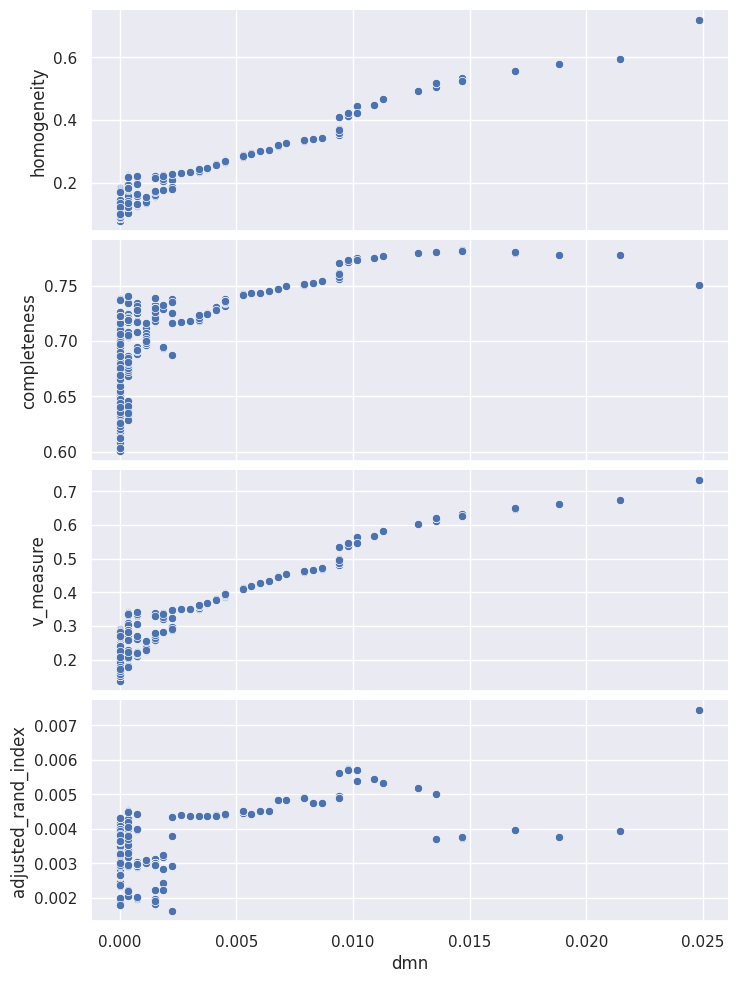

In [17]:
df = pd.DataFrame(dbscanner.metrics)
df["dmn"] = df["double_majority"] / df["total"]
import seaborn as sns

sns.set_theme()
sns.pairplot(
    df,
    x_vars=["dmn"],
    y_vars=["homogeneity", "completeness", "v_measure", "adjusted_rand_index"],
    aspect=3,
)

In [ ]:
from functools import partial
from torch.optim.lr_scheduler import StepLR
from gnn_tracking.models.track_condensation_networks import PointCloudTCN
from gnn_tracking.training.tcn_trainer import TCNTrainer
from gnn_tracking.utils.losses import (
    EdgeWeightBCELoss,
    PotentialLoss,
    BackgroundLoss,
    ObjectLoss,
)

# use cuda (gpu) if possible, otherwise fallback to cpu
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Utilizing {device}")

# use reference graph to get relevant dimensions
p = pc_builder.data_list[0]
node_indim = p.x.shape[1]
hc_outdim = 2  # output dim of latent space

# partition graphs into train, test, val splits
point_clouds = pc_builder.data_list
n_pcs = len(point_clouds)
rand_array = uniform(low=0, high=1, size=n_pcs)
train_pcs = [p for i, p in enumerate(point_clouds) if (rand_array <= 0.6)[i]]
test_pcs = [
    p
    for i, p in enumerate(point_clouds)
    if ((rand_array > 0.6) & (rand_array <= 0.8))[i]
]
val_pcs = [p for i, p in enumerate(point_clouds) if (rand_array > 0.8)[i]]

# build graph loaders
params = {"batch_size": 1, "shuffle": True, "num_workers": 2}
train_loader = DataLoader(list(train_pcs), **params)
params = {"batch_size": 1, "shuffle": False, "num_workers": 2}
test_loader = DataLoader(list(test_pcs), **params)
val_loader = DataLoader(list(val_pcs), **params)
loaders = {"train": train_loader, "test": test_loader, "val": val_loader}
print("Loader sizes:", [(k, len(v)) for k, v in loaders.items()])

# build loss function dictionary
q_min, sb = 0.01, 0.1
loss_functions = {
    "potential": PotentialLoss(q_min=q_min, device=device),
    "background": BackgroundLoss(device=device, sb=sb),
    # "object": ObjectLoss(device=device, mode='efficiency')
}

loss_weights = {
    # everything that's not mentioned here will be 1
    "potential_attractive": 1,
    "potential_repulsive": 10,
    "background": 1 / 10,
    # "object": 1/2500,
}

# set up a model and trainer
model = PointCloudTCN(
    node_indim, h_dim=8, e_dim=8, h_outdim=3, L=3, N_blocks=4, hidden_dim=100
)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
n_params = sum([np.prod(p.size()) for p in model_parameters])
print("number trainable params:", n_params)
trainer = TCNTrainer(
    model=model,
    loaders=loaders,
    loss_functions=loss_functions,
    lr=0.001,
    loss_weights=loss_weights,
    device=device,
    lr_scheduler=partial(StepLR, gamma=0.9, step_size=5),
)
trainer.train()